# Methodology: Asymmetry Analysis in Heliographic vs. Ecliptic Coordinates

This study evaluates the North-South asymmetry of solar activity under two reference frames: **Heliographic** (Carrington) and **Heliocentric Ecliptic**. The analytic pipeline involves metric definition, robust statistical inference, and geometric artifact detection.

## 1. Asymmetry Index Definition
For each time step $t$ (monthly resolution), the Normalized Asymmetry Index $A$ is calculated as:
$$ A(t) = \frac{N(t) - S(t)}{N(t) + S(t)} $$
where $N$ and $S$ represent the activity strength (sunspot area or flare intensity) in the northern and southern hemispheres. The standard error is estimated via Poisson statistics:
$$ \sigma_A(t) = \frac{2 \sqrt{N(t) \cdot S(t)}}{(N(t) + S(t))^{1.5}} $$

## 2. Statistical Inference
To rigorously compare the coordinate systems, we focus on the **magnitude** of asymmetry ($|A|$). Given the strong autocorrelation in solar cycles, standard tests are adjusted:

### 2.1 Effective Sample Size ($N_{eff}$)
We correct the degrees of freedom using the Lag-1 autocorrelation coefficient $\rho_1$:
$$ N_{eff} = N_{raw} \frac{1 - |\rho_1|}{1 + |\rho_1|} $$

### 2.2 Hypothesis Testing
*   **Paired t-test**: Parametric test checking if the mean magnitude $\overline{|A|}$ differs between systems.
*   **Wilcoxon Signed-Rank Test**: Non-parametric test checking if $|A_{Ecliptic}|$ is systematically smaller than $|A_{Heliographic}|$ (One-sided).

### 2.3 Moving Block Bootstrap (MBB)
We estimate the 95% Confidence Interval (CI) for $\overline{|A|}$ using MBB with a **block size of 12 months** to preserve annual seasonality, performing 10,000 resampling iterations.

## 3. Geometric Artifact Detection (Rosenberg-Coleman Effect)
To detect projection errors induced by Earth's orbit, we analyze the difference series $\Delta A = A_{Helio} - A_{Eclip}$.
*   **Method**: Lomb-Scargle Periodogram (sampling frequency $f_s = 12 \text{ yr}^{-1}$).
*   **Criterion**: An artifact is flagged (**YES**) if the spectral power at frequency $f \approx 1.0 \text{ year}^{-1}$ exceeds $3\times$ the median background power.

## 4. Cumulative Dynamics (CUSUM)
We compute the Cumulative Sum (CUSUM) to visualize long-term drift:
$$ \text{CUSUM}(t) = \sum_{i=0}^{t} A_i $$

--- Data Loading ---
  [OK] Loaded All SG from sg_1874_2025_all.csv
  [OK] Loaded Onset SG from sg_1874_2025_onset.csv
  [OK] Loaded Dur SG from sg_1874_2025_dur.csv
  [OK] Loaded Diss SG from sg_1874_2025_diss.csv
  [OK] Loaded Daily SG from sg_1874_2025_daily.csv
  [OK] Loaded All Flare from flare_1975_2017.csv
  [OK] Loaded Cycle Data from solar_cycle_minmax.csv

--- Start Analysis (Processing 6 Categories) ---
Calculating: All SG (Weight: area)
Calculating: Onset SG (Weight: area)
Calculating: Dur SG (Weight: area)
Calculating: Diss SG (Weight: area)
Calculating: Daily SG (Weight: area)
Calculating: All Flare (Weight: intensity)

  FINAL PUBLICATION TABLES

>>> Table 1: Data Quality, Correlation & Basic Means
    [N_Eff]: Effective sample size considering autocorrelation.
    [RMSE]: Root Mean Square Error between H and E series.
 Category  N_Raw N_Eff Artifact Ah (Mean) Ae (Mean) RMSE_Diff Spearman_R p(t-test)
   All SG   1697   763      YES    0.0186    0.0150    0.1866      0.94

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Plot saved: ../../results/02_carr_vs_eclip_dist/Fig02_Latitude_Asymmetry_Analysis.eps
Excel saved successfully.


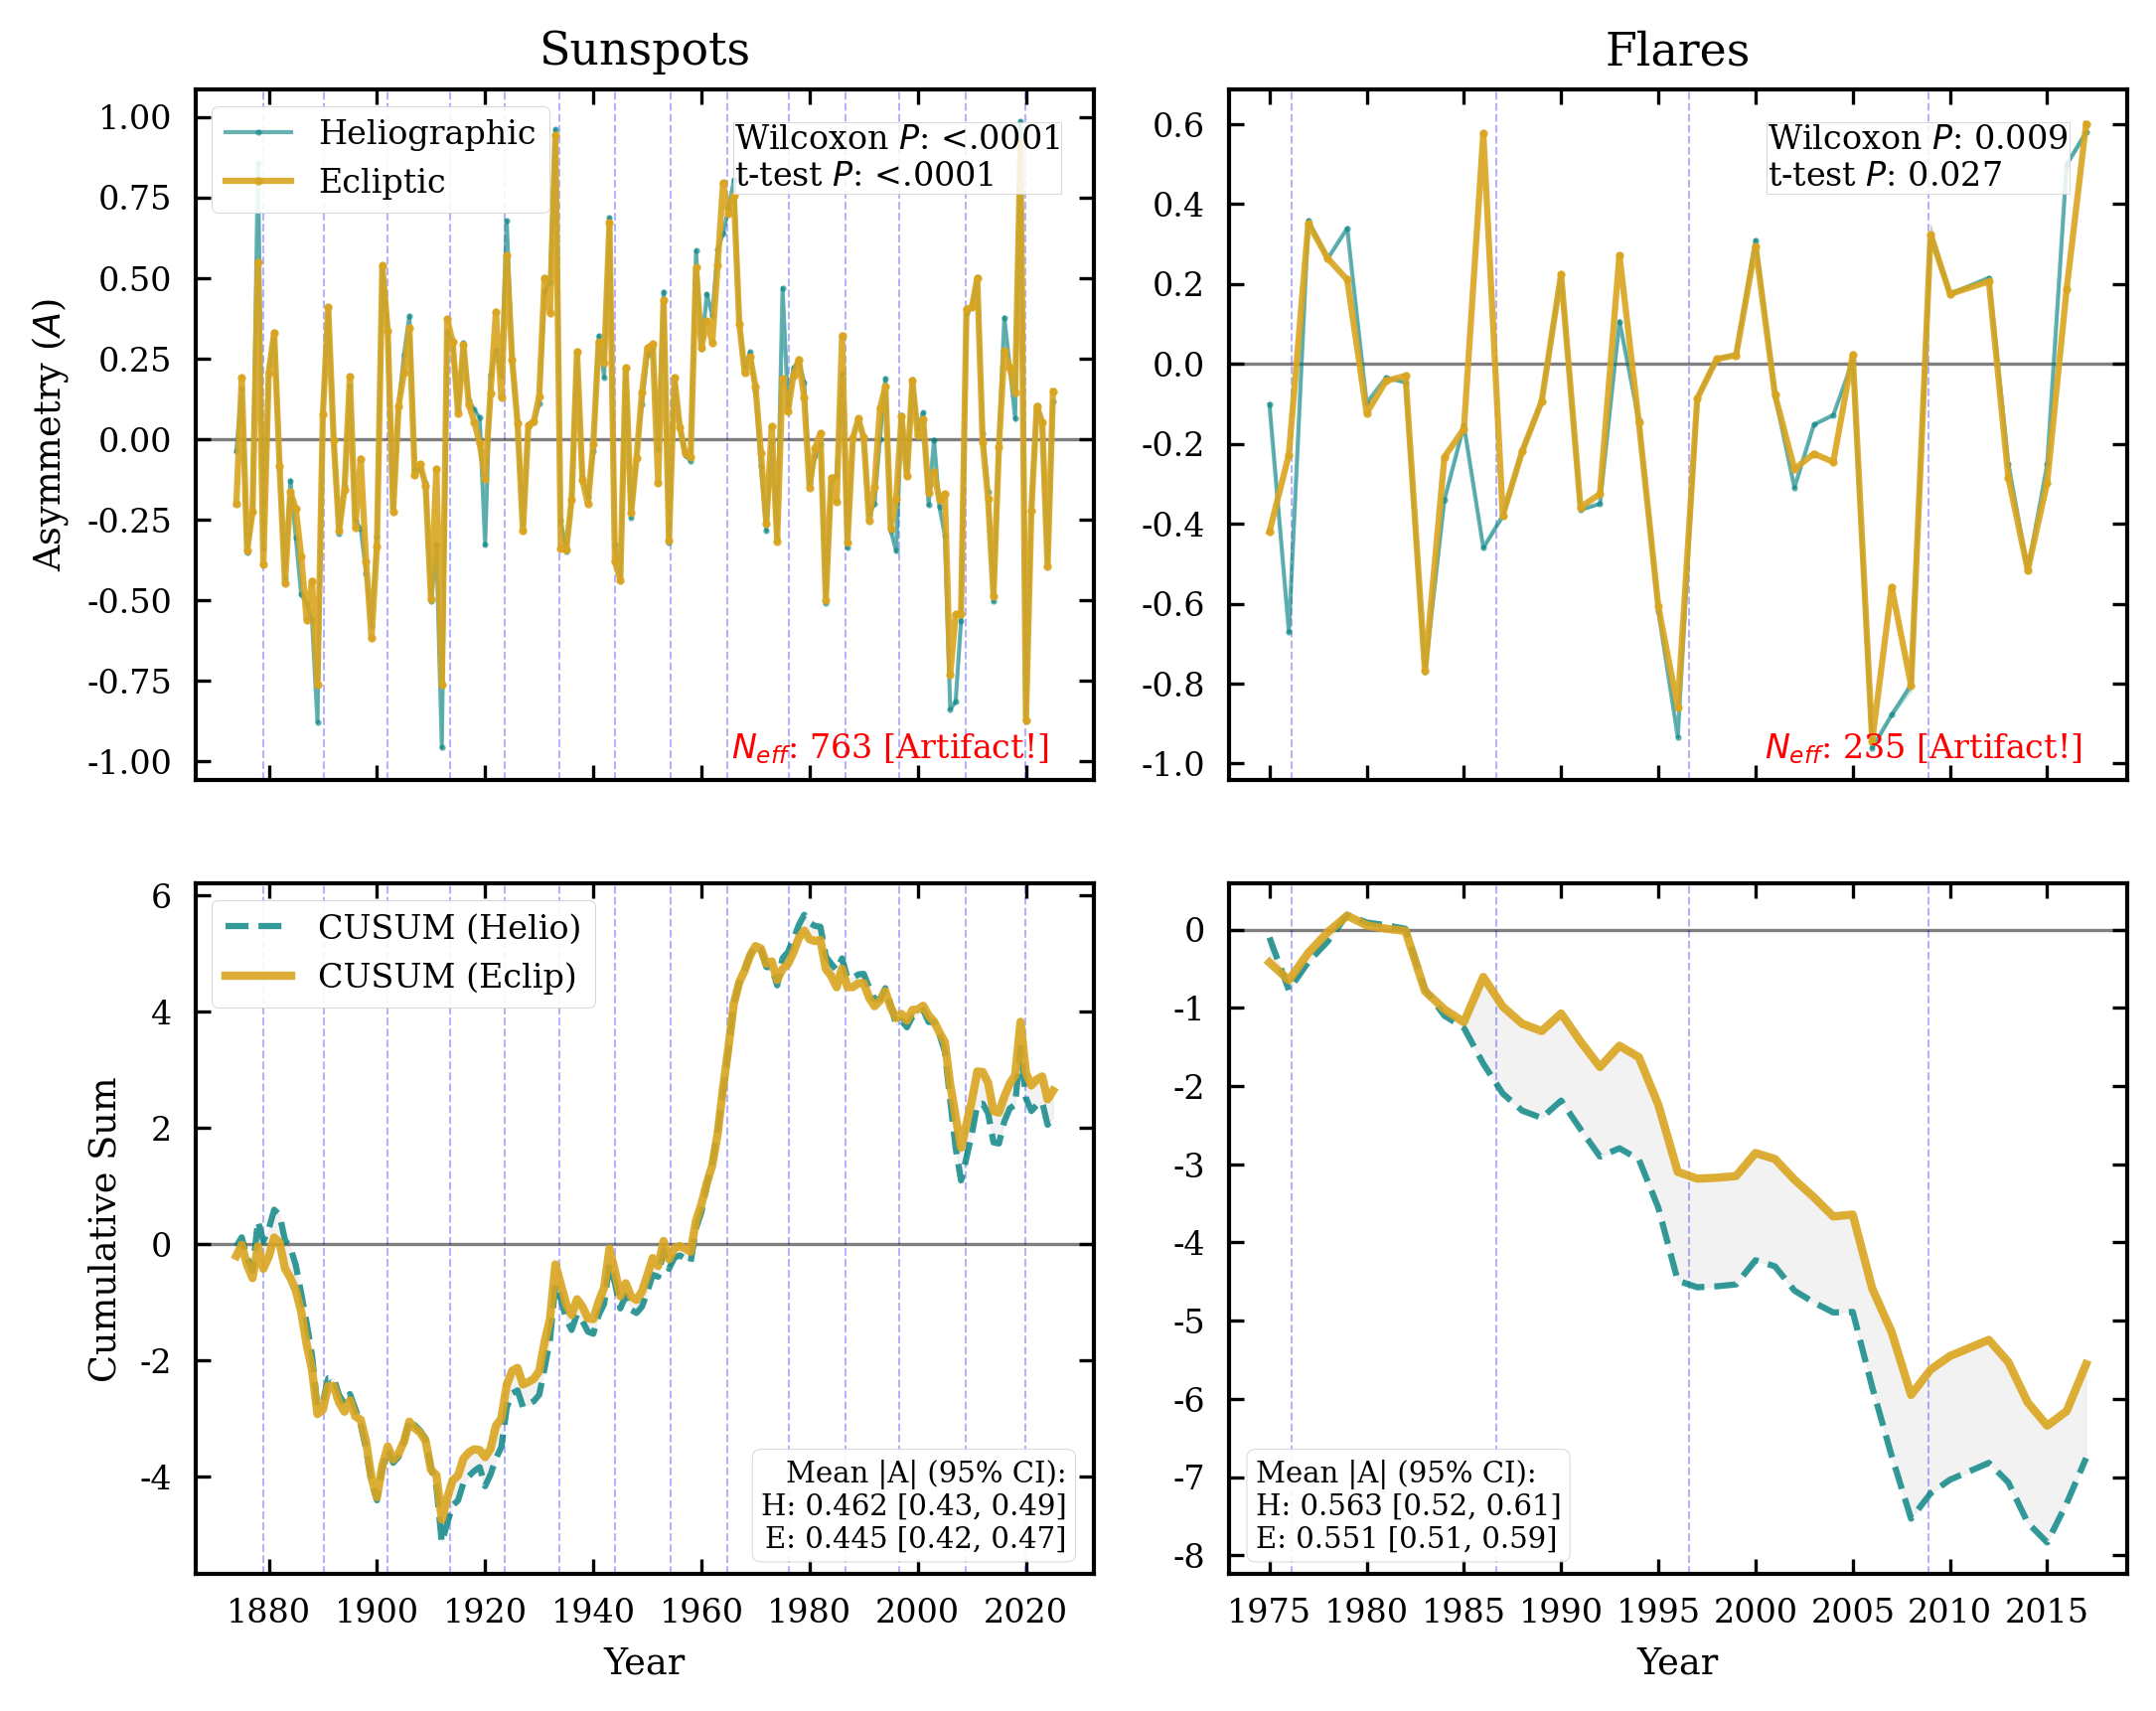

In [1]:
import pandas as pd
import numpy as np
from scipy import stats, signal
import matplotlib.pyplot as plt
import warnings
import re
import os
import sys

# Ignore warnings
warnings.filterwarnings('ignore')

# ==============================================================================
# 1. Styles Setup
# ==============================================================================
def setup_astro_style():
    try:
        plt.style.use('seaborn-v0_8-paper')
    except:
        plt.style.use('default')
    
    plt.rcParams.update({
        'font.family': 'serif', 
        'axes.unicode_minus': False,
        'figure.dpi': 300, 
        'savefig.dpi': 300,
        'axes.linewidth': 1.0,
        'xtick.direction': 'in', 'ytick.direction': 'in',
        'xtick.top': True, 'ytick.right': True,
        'legend.frameon': False
    })
setup_astro_style()

# ==============================================================================
# 2. Core Algorithms and Utility Functions
# ==============================================================================
def calculate_metrics_with_error(df_subset, time_freq, cycle_data, c_col_name, weight_col=None):
    """
    Calculate asymmetry index A and error Sigma.
    """
    df_work = df_subset.copy()
    
    # --- Date preprocessing ---
    date_col = next((c for c in ['Date', 'date', 'datetime_start'] if c in df_work.columns), None)
    if not date_col: return None, None
    df_work['Date'] = pd.to_datetime(df_work[date_col]).dt.tz_localize(None)
    df_work = df_work.dropna(subset=['Date']).reset_index(drop=True)
    if df_work.empty: return None, None

    # --- Cycle division ---
    if time_freq == 'Cycle':
        df_work['GroupBy'] = np.nan
        valid_cycles = range(10, 26) 
        if not cycle_data.empty:
            for i in range(len(cycle_data)):
                raw_val = str(cycle_data.iloc[i][c_col_name])
                found = re.search(r'(\d+)', raw_val)
                if not found: continue
                c_num = int(found.group(1))
                if c_num in valid_cycles:
                    t_start = cycle_data.iloc[i]['start_Min']
                    t_end = cycle_data.iloc[i+1]['start_Min'] if i < len(cycle_data)-1 else pd.Timestamp.max.replace(tzinfo=None)
                    mask = (df_work['Date'] >= t_start) & (df_work['Date'] < t_end)
                    df_work.loc[mask, 'GroupBy'] = c_num
        df_work = df_work.dropna(subset=['GroupBy'])
    else:
        df_work['GroupBy'] = df_work['Date'].dt.to_period(time_freq)

    # --- Statistics Calculations ---
    results = {}
    coord_map = {'Heliographic': 'hg_lat', 'Ecliptic': 'hme_lat'}
    
    for sys_name, lat_col in coord_map.items():
        if lat_col not in df_work.columns: continue
        
        # Strictly filter lat=0
        df_sys = df_work[df_work[lat_col] != 0].copy()
        mask_n = df_sys[lat_col] > 0
        mask_s = df_sys[lat_col] < 0
        
        # Weight processing
        val = df_sys[weight_col] if weight_col else 1
        df_sys['val_N'] = np.where(mask_n, val, 0)
        df_sys['val_S'] = np.where(mask_s, val, 0)
        
        grouped = df_sys.groupby('GroupBy')[['val_N', 'val_S']].sum()
        N, S = grouped['val_N'], grouped['val_S']
        Total = N + S
        
        with np.errstate(divide='ignore', invalid='ignore'):
            A = (N - S) / Total
            Sigma = (2 * np.sqrt(N * S)) / np.power(Total, 1.5)
            
            # Threshold filtering
            min_thresh = 10 if not weight_col else df_sys[weight_col].median() * 5
            mask_inv = Total < min_thresh
            A[mask_inv] = np.nan
            Sigma[mask_inv] = np.nan
            
        res_df = pd.DataFrame({'A': A, 'Sigma': Sigma})
        results[sys_name] = res_df

    if len(results) < 2: return None, None
    
    idx = results['Heliographic'].index.intersection(results['Ecliptic'].index)
    return results['Heliographic'].loc[idx], results['Ecliptic'].loc[idx]

def block_bootstrap_ci(series, block_size=12, n_boot=10000, ci=95):
    """Moving Block Bootstrap (for absolute magnitude |A|)"""
    data = series.dropna().values
    n = len(data)
    if n < block_size * 2: return np.nan, np.nan, np.nan
    
    blocks = [data[i : i + block_size] for i in range(n - block_size + 1)]
    means = []
    rng = np.random.default_rng(42)
    n_blocks_needed = int(np.ceil(n / block_size))
    
    for _ in range(n_boot):
        chosen_indices = rng.integers(0, len(blocks), size=n_blocks_needed)
        sample = np.concatenate([blocks[i] for i in chosen_indices])[:n]
        means.append(np.mean(np.abs(sample))) # Note: Table 2 focuses on absolute magnitude
        
    lower = (100 - ci) / 2
    return np.percentile(means, lower), np.mean(means), np.percentile(means, 100 - lower)

def calculate_cusum_slope(series_data):
    """Calculate CUSUM and slope"""
    cusum = np.cumsum(series_data.fillna(0).values)
    x = np.arange(len(cusum))
    if len(x) > 1:
        res = stats.linregress(x, cusum)
        return res.slope, cusum
    return np.nan, cusum

def test_cusum_significance(series, observed_slope, n_perm=1000, block_size=12):
    """CUSUM Slope significance test"""
    vals = series.dropna().values
    n = len(vals)
    if n < block_size: return np.nan
    blocks = [vals[i:i+block_size] for i in range(0, n, block_size)]
    rng = np.random.default_rng(42)
    slopes = []
    x = np.arange(n)
    for _ in range(n_perm):
        current_blocks = blocks[:]
        rng.shuffle(current_blocks)
        shuffled = np.concatenate(current_blocks)[:n]
        cusum_shuffled = np.cumsum(shuffled)
        res = stats.linregress(x, cusum_shuffled)
        slopes.append(res.slope)
    p_val = np.mean(np.abs(slopes) >= np.abs(observed_slope))
    return p_val

def check_geometric_artifact(diff_series, threshold_ratio=3.0):
    """
    Geometric Artifact Detection (1-year period signal) based on Periodogram
    """
    if diff_series.empty: return 'NO', 0.0
    
    # 1. Detrend and demean
    sig = diff_series.dropna() - diff_series.mean()
    if len(sig) < 12: return 'NO', 0.0
    
    # 2. Lomb-Scargle Periodogram
    # Target frequency: 1 cycle/year. Monthly data freq = 1/12 cycle/month
    f, Pxx = signal.periodogram(sig, fs=12.0) # fs=12 (data per year)
    
    # Peak at 1.0 year^-1 (0.9 - 1.1)
    mask_1yr = (f >= 0.9) & (f <= 1.1)
    if not np.any(mask_1yr): return 'NO', 0.0
    
    power_1yr = np.max(Pxx[mask_1yr])
    median_power = np.median(Pxx)
    
    # Criterion: 1-year period power > 3 * median power
    is_artifact = 'YES' if power_1yr > threshold_ratio * median_power else 'NO'
    return is_artifact, power_1yr

def convert_to_intensity(row):
    """Convert Flare class to Intensity"""
    try:
        raw = str(row['xray_class']).strip().upper()
        if not raw or raw == 'NAN': return 0
        type_mult = {'A':1, 'B':10, 'C':100, 'M':1000, 'X':10000}
        mult = type_mult.get(raw[0], 0)
        val = float(raw[1:]) if len(raw)>1 else 1.0
        return mult * val
    except: return 0

# ==============================================================================
# 3. Statistical Analysis Module (Integrated Table 1 and Table 2 metrics)
# ==============================================================================
def calculate_advanced_stats(df_cat, df_cycle, cycle_col, cat_name, weight_col=None):
    # 1. Calculate basic metrics
    res_h_m, res_e_m = calculate_metrics_with_error(df_cat, 'M', df_cycle, cycle_col, weight_col)
    res_h_y, res_e_y = calculate_metrics_with_error(df_cat, 'Y', df_cycle, cycle_col, weight_col)
    
    if res_h_m is None: return None, None

    # Get monthly data values (exclude NaN)
    common_idx = res_h_m['A'].dropna().index.intersection(res_e_m['A'].dropna().index)
    h_series = res_h_m.loc[common_idx, 'A']
    e_series = res_e_m.loc[common_idx, 'A']
    h_vals = h_series.values
    e_vals = e_series.values
    
    # --- 1. Basic Statistics (Table 1) ---
    mean_h_raw = np.mean(h_vals)
    mean_e_raw = np.mean(e_vals)
    rms_h = np.sqrt(np.mean(h_vals**2))
    rms_e = np.sqrt(np.mean(e_vals**2))
    rmse_diff = np.sqrt(np.mean((h_vals - e_vals)**2)) # New: RMSE of difference
    
    # Spearman correlation (New)
    try: spearman_r, _ = stats.spearmanr(h_vals, e_vals)
    except: spearman_r = np.nan

    # Effective sample size N_eff (New)
    rho = h_series.autocorr(lag=1)
    n_raw = len(h_vals)
    n_eff = n_raw * (1 - rho) / (1 + rho) if abs(rho) < 0.99 else n_raw
    
    # Geometric artifact check (New)
    diff = h_series - e_series
    has_artifact, _ = check_geometric_artifact(diff)
    
    # Paired t-test (on absolute values)
    try: _, p_ttest = stats.ttest_rel(np.abs(h_vals), np.abs(e_vals))
    except: p_ttest = np.nan

    # --- 2. Advanced Tests (Table 2) ---
    # Wilcoxon (one-tailed: E < H ?)
    try: _, p_wilcoxon = stats.wilcoxon(np.abs(e_vals), np.abs(h_vals), alternative='less')
    except: p_wilcoxon = np.nan

    # KS Test (distribution shape) (New)
    try: _, p_ks = stats.ks_2samp(np.abs(h_vals), np.abs(e_vals))
    except: p_ks = np.nan

    # Levene Test (variance homogeneity) (New)
    try: _, p_levene = stats.levene(h_vals, e_vals)
    except: p_levene = np.nan
        
    # Bootstrap CI (absolute mean)
    low_h, mean_h_boot, high_h = block_bootstrap_ci(h_series, block_size=12)
    low_e, mean_e_boot, high_e = block_bootstrap_ci(e_series, block_size=12)

    # CUSUM Slope
    slope_h, cusum_h = calculate_cusum_slope(res_h_y['A'])
    slope_e, cusum_e = calculate_cusum_slope(res_e_y['A'])
    
    stats_result = {
        'Category': cat_name,
        
        # --- Table 1 Columns ---
        'N_Raw': n_raw,
        'N_Eff': n_eff,            # New
        'Artifact': "YES" if has_artifact else "No", # New
        'Ah (Mean)': mean_h_raw,
        'Ae (Mean)': mean_e_raw,
        'RMSE_Diff': rmse_diff,    # New
        'Spearman_R': spearman_r,  # New
        'p(t-test)': p_ttest,
        
        # --- Table 2 Columns ---
        'Wilcoxon_P': p_wilcoxon,
        'KS_Test_P': p_ks,         # New
        'Levene_P': p_levene,      # New
        'Boot_Mean_H': mean_h_boot,
        'Boot_CI_H_Low': low_h,
        'Boot_CI_H_High': high_h,
        'Boot_Mean_E': mean_e_boot,
        'Boot_CI_E_Low': low_e,
        'Boot_CI_E_High': high_e
    }
    
    plot_data = (res_h_y, res_e_y, cusum_h, cusum_e)
    return stats_result, plot_data

# ==============================================================================
# 4. Main Execution
# ==============================================================================
def main():
    output_dir = '../../results/02_carr_vs_eclip_dist/'
    os.makedirs(output_dir, exist_ok=True)
    base_path = '../../data/ready/'

    dfs = {}
    print("--- Data Loading ---")
    
    try:
        # ======================================================================
        # 1. Load Sunspot Group Data
        # ======================================================================
        sg_stages = {
            'All SG': 'sg_1874_2025_all.csv',
            'Onset SG': 'sg_1874_2025_onset.csv',
            'Dur SG': 'sg_1874_2025_dur.csv',
            'Diss SG': 'sg_1874_2025_diss.csv',
            'Daily SG': 'sg_1874_2025_daily.csv'
        }
        
        for label, fname in sg_stages.items():
            full_p = os.path.join(base_path, fname)
            if os.path.exists(full_p):
                try: df_tmp = pd.read_csv(full_p)
                except: df_tmp = pd.read_csv(full_p, encoding='gbk')
                df_tmp.columns = [c.lower() for c in df_tmp.columns]
                dfs[label] = df_tmp
                print(f"  [OK] Loaded {label} from {fname}")
            else:
                print(f"  [Warn] File not found: {fname}")
        
        # ======================================================================
        # 2. Load Flare Data
        # ======================================================================
        flare_name = 'flare_1975_2017.csv'
        full_p = os.path.join(base_path, flare_name)
        if os.path.exists(full_p):
            try: df_flare = pd.read_csv(full_p)
            except: df_flare = pd.read_csv(full_p, encoding='gbk')
            df_flare.columns = [c.lower() for c in df_flare.columns]
            
            if 'intensity' not in df_flare.columns:
                df_flare['intensity'] = df_flare.apply(convert_to_intensity, axis=1)
            dfs['All Flare'] = df_flare
            print(f"  [OK] Loaded All Flare from {flare_name}")
        else:
            print(f"  [Warn] Flare file not found: {flare_name}")
        
        # ======================================================================
        # 3. Load Cycle Table
        # ======================================================================
        cycle_names = 'solar_cycle_minmax.csv'
        df_cycle = pd.DataFrame()
        cpath = os.path.join(base_path, cycle_names)
        df_cycle = pd.read_csv(cpath)
        print(f"  [OK] Loaded Cycle Data from {cycle_names}")
        
        if df_cycle.empty:
            print("  [Error] Cycle data file not found!"); return
            
        cycle_col = next((c for c in ['SC', 'Cycle', 'Cycle No'] if c in df_cycle.columns), 'SC')
        df_cycle['start_Min'] = pd.to_datetime(df_cycle['start_Min']).dt.tz_localize(None)
        df_cycle = df_cycle.sort_values('start_Min').reset_index(drop=True)

    except Exception as e:
        print(f"Data loading process encountered an error: {e}"); sys.exit()

    stats_collection = {}
    plot_data_collection = {}

    print("\n--- Start Analysis (Processing 6 Categories) ---")

    # Define processing order (ensure table has 6 rows in correct order)
    process_order = ['All SG', 'Onset SG', 'Dur SG', 'Diss SG', 'Daily SG', 'All Flare']
    
    for cat_name in process_order:
        if cat_name not in dfs: 
            continue
        
        df_dat = dfs[cat_name]
        if df_dat.empty: continue

        w_col = None
        # Since we converted to lowercase above, directly check 'area' / 'intensity'
        if 'area' in df_dat.columns: w_col = 'area'
        elif 'intensity' in df_dat.columns: w_col = 'intensity'
        
        print(f"Calculating: {cat_name} (Weight: {w_col if w_col else 'Count'})")
        
        adv_res, plot_dat = calculate_advanced_stats(df_dat, df_cycle, cycle_col, cat_name, w_col)
        
        if adv_res:
            stats_collection[cat_name] = adv_res
            plot_data_collection[cat_name] = plot_dat

    # ==========================================================================
    # 5. Terminal Report Output (Table 1 & Table 2)
    # ==========================================================================
    try:
        df_report = pd.DataFrame(list(stats_collection.values()))
        
        if not df_report.empty:
            # Sort by process_order
            df_report['Category'] = pd.Categorical(df_report['Category'], categories=process_order, ordered=True)
            df_report = df_report.sort_values('Category')

            pd.set_option('display.max_rows', None)
            pd.set_option('display.width', 1000)
            pd.set_option('display.max_colwidth', 20)

            print("\n" + "="*110)
            print("  FINAL PUBLICATION TABLES")
            print("="*110)

            # --- Table 1 ---
            print("\n>>> Table 1: Data Quality, Correlation & Basic Means")
            print("    [N_Eff]: Effective sample size considering autocorrelation.")
            print("    [RMSE]: Root Mean Square Error between H and E series.")
            
            cols_t1 = ['Category', 'N_Raw', 'N_Eff', 'Artifact', 
                       'Ah (Mean)', 'Ae (Mean)', 'RMSE_Diff', 'Spearman_R', 'p(t-test)']
            
            formatters = {
                'N_Eff': '{:.0f}'.format,
                'Ah (Mean)': '{:.4f}'.format, 'Ae (Mean)': '{:.4f}'.format,
                'RMSE_Diff': '{:.4f}'.format, 'Spearman_R': '{:.3f}'.format,
                'p(t-test)': lambda x: '<.0001' if x < 0.0001 else '{:.4f}'.format(x)
            }
            print(df_report[cols_t1].to_string(index=False, formatters=formatters))

            # --- Table 2 ---
            print("\n>>> Table 2: Robust Hypothesis Tests (P-values) & Bootstrap Estimates")
            print("    [KS]: Kolmogorov-Smirnov (Shape), [Levene]: Variance Homogeneity")
            
            cols_t2 = ['Category', 'Wilcoxon_P', 'KS_Test_P', 'Levene_P',
                       'Boot_Mean_H', 'Boot_CI_H_Low', 'Boot_CI_H_High', 
                       'Boot_Mean_E'] 
            cols_t2_full = cols_t2 + ['Boot_CI_E_Low', 'Boot_CI_E_High']
            
            formatters_t2 = {
                'Wilcoxon_P': lambda x: '<.0001' if x < 0.0001 else '{:.4f}'.format(x),
                'KS_Test_P': lambda x: '<.0001' if x < 0.0001 else '{:.4f}'.format(x),
                'Levene_P': lambda x: '<.0001' if x < 0.0001 else '{:.4f}'.format(x),
                'Boot_Mean_H': '{:.3f}'.format, 'Boot_Mean_E': '{:.3f}'.format,
                'Boot_CI_H_Low': '{:.3f}'.format, 'Boot_CI_H_High': '{:.3f}'.format,
                'Boot_CI_E_Low': '{:.3f}'.format, 'Boot_CI_E_High': '{:.3f}'.format
            }
            
            print(df_report[cols_t2_full].to_string(index=False, formatters=formatters_t2))
            print("="*110 + "\n")
            
    except Exception as e:
        print(f"Terminal table output failed: {e}")

    # ==========================================================================
    # Plotting Logic (All SG vs All Flare)
    # ==========================================================================
    if 'All SG' in plot_data_collection and 'All Flare' in plot_data_collection:
        print("--- Generating Plot ---")
         # Width 7.2 (double-column), Height 6 (11.5 inches is close to A4 full page height)
        fig, axes = plt.subplots(2, 2, figsize=(7.2, 6), sharex='col', sharey=False)
        
        targets = [('All SG', 0, 'Sunspots'), ('All Flare', 1, 'Flares')]
        colors = {'H': 'teal', 'E': 'goldenrod'}

        for key, col, title_base in targets:
            sh_y, se_y, cusum_h, cusum_e = plot_data_collection[key]
            stats_res = stats_collection[key]
            years = sh_y.index.to_timestamp()
            
            # Background cycle lines
            t_min, t_max = years.min(), years.max()
            for _, row in df_cycle.iterrows():
                tm = row['start_Min']
                if t_min <= tm <= t_max:
                    for ax in axes[:, col]: 
                        ax.axvline(tm, c='blue', ls='--', lw=0.5, alpha=0.3)

            # Row 1: A Index
            ax1 = axes[0, col]
            ax1.axhline(0, c='k', lw=0.8, alpha=0.5)
            Ah, SigH = sh_y['A'], sh_y['Sigma']
            Ae, SigE = se_y['A'], se_y['Sigma']
            
            ax1.fill_between(years, Ah-SigH, Ah+SigH, color=colors['H'], alpha=0.15)
            ax1.plot(years, Ah, '.-', c=colors['H'], alpha=0.6, lw=1, ms=3, label='Heliographic')
            ax1.fill_between(years, Ae-SigE, Ae+SigE, color=colors['E'], alpha=0.15)
            ax1.plot(years, Ae, '.-', c=colors['E'], alpha=0.9, lw=1.5, ms=4, label='Ecliptic')
            ax1.set_title(f"{title_base}", fontsize=11)
            
            def fmt_p(p): return "<.0001" if p<0.0001 else f"{p:.3f}"
            artifact_warn = " [Artifact!]" if stats_res['Artifact'] == 'YES' else ""
            info_text = (
                f"Wilcoxon $P$: {fmt_p(stats_res['Wilcoxon_P'])}\n"
                f"t-test $P$: {fmt_p(stats_res['p(t-test)'])}"
            )
            ax1.text(0.6, 0.95, info_text, transform=ax1.transAxes, va='top', fontsize=8,
                     bbox=dict(facecolor='white', alpha=0.85, pad=0.3, edgecolor='lightgray'))
            
            ax1.text(0.95, 0.07, f"$N_{{eff}}$: {stats_res['N_Eff']:.0f}{artifact_warn}",
                     transform=ax1.transAxes, ha='right', va='top', fontsize=8,
                     color='red' if artifact_warn else 'black')

            if col == 0: ax1.set_ylabel('Asymmetry ($A$)')
            
            # Row 2: CUSUM
            ax2 = axes[1, col]
            ax2.axhline(0, c='k', lw=0.8, alpha=0.5)
            ax2.plot(years, cusum_h, '--', c=colors['H'], alpha=0.8, lw=1.5, label='CUSUM (Helio)')
            ax2.plot(years, cusum_e, '-', c=colors['E'], alpha=0.9, lw=2, label='CUSUM (Eclip)')
            ax2.fill_between(years, cusum_h, cusum_e, color='gray', alpha=0.1)

            boot_info = (f"Mean |A| (95% CI):\n"
                         f"H: {stats_res['Boot_Mean_H']:.3f} [{stats_res['Boot_CI_H_Low']:.2f}, {stats_res['Boot_CI_H_High']:.2f}]\n"
                         f"E: {stats_res['Boot_Mean_E']:.3f} [{stats_res['Boot_CI_E_Low']:.2f}, {stats_res['Boot_CI_E_High']:.2f}]")
            
            x_pos = 0.97 if col == 0 else 0.03
            ha = 'right' if col == 0 else 'left'
            ax2.text(x_pos, 0.03, boot_info, transform=ax2.transAxes, ha=ha, va='bottom', fontsize=7,
                     bbox=dict(facecolor='white', alpha=0.9, boxstyle='round,pad=0.3', edgecolor='lightgray'))

            if col == 0: ax2.set_ylabel('Cumulative Sum')
            ax2.set_xlabel('Year')
            
            # Legend optimization: Place at best location, font size 8pt, with white background to prevent overlapping curves
            if col == 0:
                # Add legend for ax1 (Asymmetry)
                ax1.legend(loc='upper left', fontsize=8, 
                           frameon=True, facecolor='white', framealpha=0.9, edgecolor='lightgray')
                # Add legend for ax2 (CUSUM)
                ax2.legend(loc='upper left', fontsize=8, 
                           frameon=True, facecolor='white', framealpha=0.9, edgecolor='lightgray')

        plt.subplots_adjust(left=0.08, right=0.98, top=0.93, bottom=0.1, wspace=0.15, hspace=0.15)
        plot_path = f'{output_dir}Fig02_Latitude_Asymmetry_Analysis.eps'
        plt.savefig(plot_path, format='eps', bbox_inches='tight')
        print(f"Plot saved: {plot_path}")

    # Excel Output
    try:
        with pd.ExcelWriter(f'{output_dir}Fig02_Latitude_Source.xlsx', engine='xlsxwriter') as writer:
            pd.DataFrame(list(stats_collection.values())).to_excel(writer, sheet_name='Stats', index=False)
            curve_dfs = []
            for k, (ch, ce, cush, cuse) in plot_data_collection.items():
                d = pd.DataFrame({
                    f'{k}_Ah': ch['A'], f'{k}_Ae': ce['A'],
                    f'{k}_CUSUM_h': cush, f'{k}_CUSUM_e': cuse
                })
                curve_dfs.append(d)
            if curve_dfs: pd.concat(curve_dfs, axis=1).to_excel(writer, sheet_name='Curves')
        print("Excel saved successfully.")
    except Exception as e: print(f"Excel Error: {e}")

if __name__ == '__main__':
    main()